In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3, xception, efficientnet, mobilenet_v3

import numpy as np
from tqdm import tqdm

from IPython.display import Image, display

In [2]:
image_path = keras.utils.get_file("mars.jpg", 'https://i.imgur.com/YYdfZ59.jpeg')

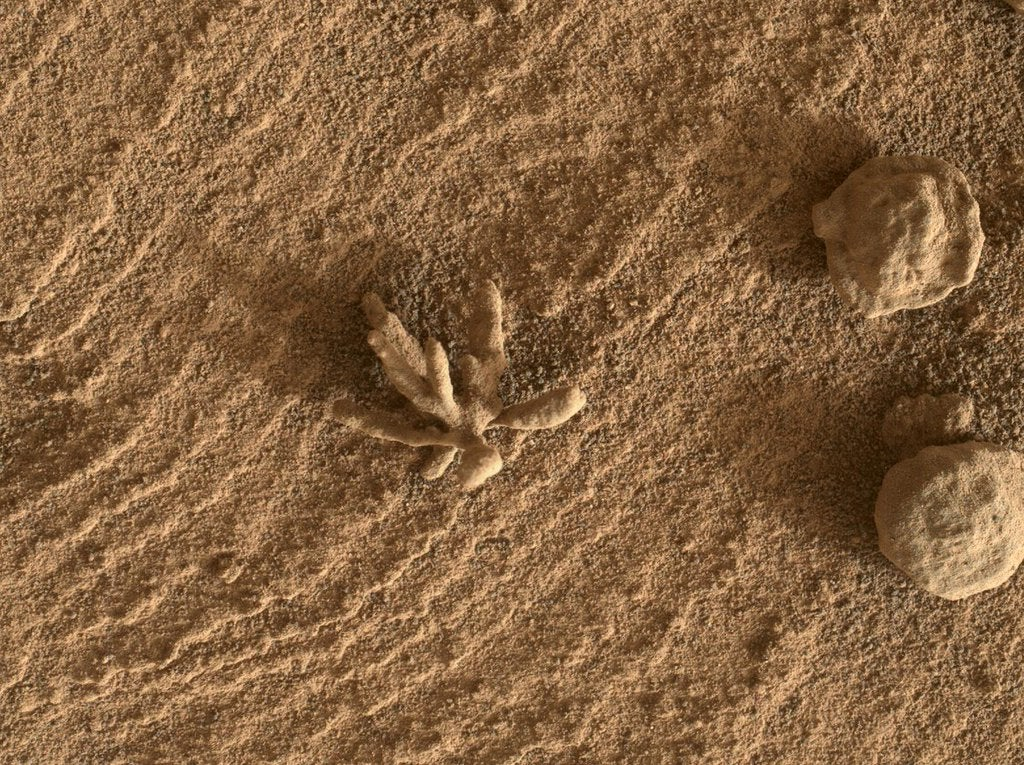

In [3]:
display(Image(image_path))

In [4]:
def create_inception_v3_feature_extractor():
    layer_settings = {
        "mixed4": 1.0,
        "mixed5": 1.5,
        "mixed6": 2.0,
        "mixed7": 2.5,
    }

    model = inception_v3.InceptionV3(weights="imagenet", include_top=False)
    model.summary()

    outputs = dict([(layer.name, layer.output)
                    for layer in [model.get_layer(name) for name in layer_settings.keys()]])

    return keras.Model(inputs=model.inputs, outputs=outputs), layer_settings


keras.backend.clear_session()
feature_extractor, layer_settings = create_inception_v3_feature_extractor()
feature_extractor.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
def create_xception_feature_extractor():
    layer_settings = {
        'block2_sepconv2_act': 0.5,
        'block6_sepconv3_act': 1.0,
        'block10_sepconv3_act': 2.0,
        'block14_sepconv2_act': 3.0,
    }

    model = xception.Xception(include_top=False, weights='imagenet')
    
    outputs = dict([(layer.name, layer.output)
                    for layer in [model.get_layer(name) for name in layer_settings.keys()]])

    return keras.Model(inputs=model.inputs, outputs=outputs), layer_settings


keras.backend.clear_session()
feature_extractor, layer_settings = create_xception_feature_extractor()
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [6]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def compute_loss(image):
    features = feature_extractor(image)
    loss = tf.zeros(shape=())
    for l in layer_settings:
        values = features[l]
        scaling = tf.reduce_prod(tf.shape(values))
        scaling = tf.cast(scaling, tf.float32)
        loss += tf.reduce_sum(tf.square(values[:, 2:-2, 2:-2, :]) * layer_settings[l] / scaling)
    return loss


@tf.function(jit_compile=True)
def train_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grad = tape.gradient(loss, image)
    grad /= tf.maximum(tf.reduce_mean(tf.abs(grad)), 1e-6)
    image += learning_rate * grad
    return image, loss


image = preprocess_image(image_path)
image = tf.identity(image)
learning_rate = 0.01
image, loss = train_step(image, learning_rate)

In [7]:
def train(image, learning_rate, steps):
    for step in tqdm(range(steps)):
        image, loss = train_step(image, learning_rate)
    print('loss: %f' % loss.numpy())
    return image, loss


steps = 20
image, loss = train(image, learning_rate, steps)

100%|██████████| 20/20 [00:00<00:00, 20.71it/s]


loss: 5.696127


In [8]:
EPOCHS = 10

for epoch in range(EPOCHS):
    image, loss = train(image, learning_rate, steps)

 25%|██▌       | 5/20 [00:00<00:00, 36.97it/s]

loss: 14.779315


 25%|██▌       | 5/20 [00:00<00:00, 37.10it/s]

loss: 32.144005


 25%|██▌       | 5/20 [00:00<00:00, 37.13it/s]

loss: 50.930672


 25%|██▌       | 5/20 [00:00<00:00, 36.80it/s]

loss: 69.309479


 25%|██▌       | 5/20 [00:00<00:00, 37.00it/s]

loss: 93.382790


 25%|██▌       | 5/20 [00:00<00:00, 37.02it/s]

loss: 116.213814


 25%|██▌       | 5/20 [00:00<00:00, 36.68it/s]

loss: 139.606033


 25%|██▌       | 5/20 [00:00<00:00, 37.92it/s]

loss: 155.774582


 25%|██▌       | 5/20 [00:00<00:00, 37.87it/s]

loss: 174.325668


100%|██████████| 20/20 [00:00<00:00, 22.73it/s]


loss: 194.841766


In [9]:
def postprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.0
    x += 0.5
    x *= 255.0
    x = np.clip(x, 0, 255).astype("uint8")
    return x


output_image = postprocess_image(image.numpy())
keras.preprocessing.image.save_img('output.png', output_image)

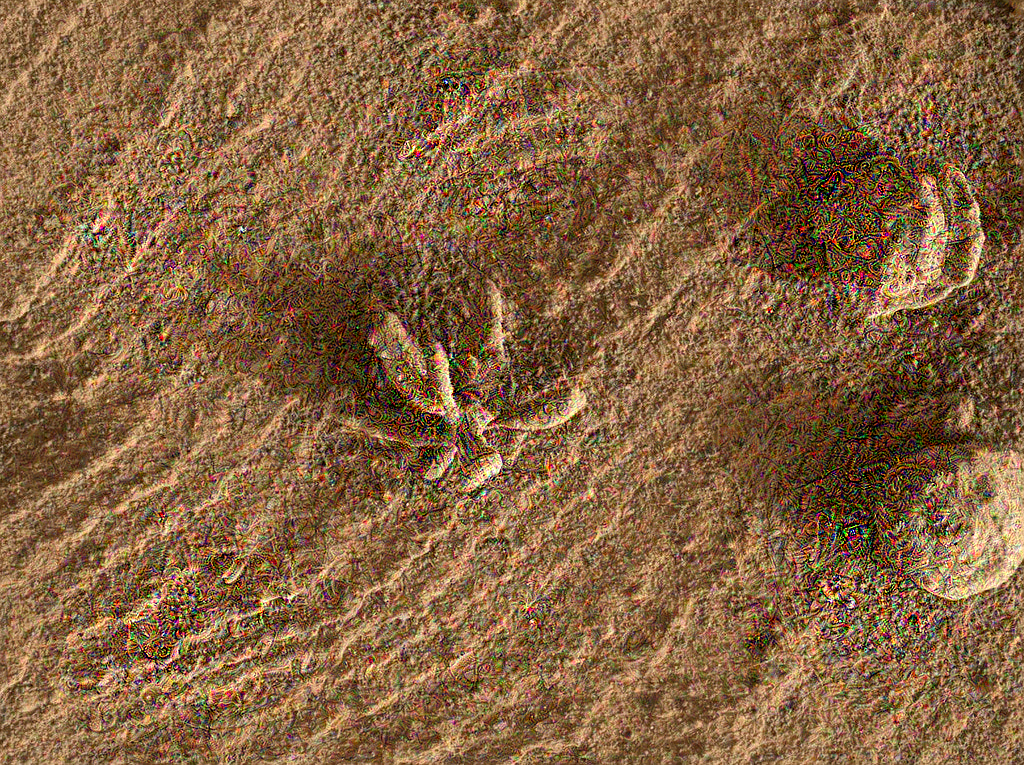

In [10]:
display(Image('output.png'))